In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn

# Set seed
np.random.seed(651017568)

In [2]:
# Team members
# Olek [oyardas2]
# Dreycen [dfoiles2]

# Contribution break-up


### Generate Centers

In [3]:
p = 2 # for bivariate gaussian
csize = 10 # number of gaussians
sigma = 1 # variance
m1 = np.random.normal(size = (csize, p)) * sigma + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * sigma + np.concatenate([np.array([[0, 1]] * csize)])

class sim_params :
    csize = 10           # number of centers
    p = 2                # dimension
    s = np.sqrt(1 / 5)   # standard deviation for generating data
    n = 200              # training size per class
    N = 10000             # test size per class
    m0 = m0              # 10 centers for class 0
    m1 = m1              # 10 centers for class 1

### Generate Data

In [4]:
def generate_sim_data(sim_params):

    p = sim_params.p
    s = sim_params.s
    n = sim_params.n
    N = sim_params.N
    m1 = sim_params.m1
    m0 = sim_params.m0
    csize = sim_params.csize
    
    id1 = np.random.randint(csize, size = n)
    id0 = np.random.randint(csize, size = n)

    Xtrain = np.random.normal(size = (2 * n, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    Ytrain = np.concatenate(([1]*n, [0]*n))

    id1 = np.random.randint(csize, size = N)
    id0 = np.random.randint(csize, size = N)
    Xtest = np.random.normal(size = (2 * N, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    Ytest = np.concatenate(([1]*N, [0]*N))

    return Xtrain, Ytrain, Xtest, Ytest



Use the function above to generate a set of training and test data.


In [5]:
Xtrain, Ytrain, Xtest, Ytest = generate_sim_data(sim_params)

### Visualization

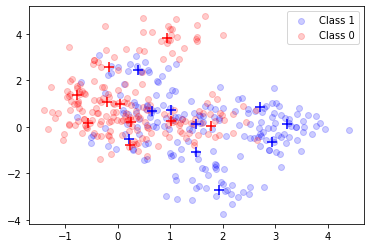

In [7]:
n = sim_params.n
m0 = sim_params.m0        
m1 = sim_params.m1

plt.figure()
plt.scatter(Xtrain[:n, 0], Xtrain[:n, 1], 
            color = 'blue', alpha = 0.2, label = 'Class 1')
plt.scatter(Xtrain[n:, 0], Xtrain[n:, 1], 
            color = 'red', alpha = 0.2, label = 'Class 0')
plt.scatter(m1[:, 0], m1[:, 1], marker = '+', color = 'blue', s = 120)
plt.scatter(m0[:, 0], m0[:, 1], marker = '+', color = 'red', s = 120)
plt.legend()
plt.show()

## Part I: kNN

In [8]:
from scipy.spatial.distance import pdist

In [26]:
def dist(p1,p2):

    return np.sqrt(np.sum((p1 - p2)**2,axis=1))

def my_knn(k, Xtrain, Ytrain, Xtest):
    Ytest_hat = []
    for xtest in Xtest:

        # distances = []
        # kclosest = []
        ## to implemet
        distances = dist(xtest, Xtrain)

        sorted_indices = np.argsort(np.array(distances))
        sorted_Ytrain = Ytrain[sorted_indices]

        k_nn_Ytrain = sorted_Ytrain[:k]

        p1 = 1/k * np.sum(k_nn_Ytrain) # prob that xtrain is class 1
        p0 = 1 - p1
        
        
        if p1 > p0:
            ytest = 1
        elif p1 < p0:
            ytest = 0
        else:
            # flip a coin
            ytest = np.random.randint(2)
            
        Ytest_hat.append(ytest)
    return np.array(Ytest_hat)

Compare your results with the ones from `sklearn.neighbors.KNeighborsClassifier`

In [27]:
def confusion_matrix(Ytrue, Ypred):
    return np.bincount(Ytrue + 2*Ypred).reshape(2, 2)

In [28]:
k = 1
print(f'K = {k}: ')
Ytest = my_knn(k, Xtrain, Ytrain, Xtest).astype('int64')
knn_model = knn(n_neighbors = k)
knn_model.fit(Xtrain, Ytrain)
test_pred = knn_model.predict(Xtest)
confusion_matrix(Ytest, test_pred) # same as pd.crosstab

K = 1: 


array([[ 9902,     0],
       [    0, 10098]], dtype=int64)

In [29]:
k = 3
print(f'K = {k}: ')
Ytest = my_knn(k, Xtrain, Ytrain, Xtest).astype('int64')
knn_model = knn(n_neighbors = k)
knn_model.fit(Xtrain, Ytrain)
test_pred = knn_model.predict(Xtest)
confusion_matrix(Ytest, test_pred) # same as pd.crosstab

K = 3: 


array([[ 9927,     0],
       [    0, 10073]], dtype=int64)

In [30]:
k = 5
print(f'K = {k}: ')
Ytest = my_knn(k, Xtrain, Ytrain, Xtest).astype('int64')
knn_model = knn(n_neighbors = k)
knn_model.fit(Xtrain, Ytrain)
test_pred = knn_model.predict(Xtest)
confusion_matrix(Ytest, test_pred) # same as pd.crosstab

K = 5: 


array([[10076,     0],
       [    0,  9924]], dtype=int64)

**Our function appears to generate correct predictions. The confusion matrix has no false positives or negatives.**

In [31]:
pd.crosstab(test_pred,Ytest)

col_0,0,1
row_0,,
0,10076,0
1,0,9924


In [32]:
np.mean(test_pred != Ytest)

0.0


## Part II: cv-KNN

Sample code for computing CV error for a particular K value.


In [53]:
def cv_error(K, traindata, Ytrain, num_folds):

    # num_folds = 10
    n = len(Ytrain)
    fold_size = int(n / num_folds)
    err = 0

    indices = np.arange(n)
    np.random.shuffle(indices)
    index_sets = np.array_split(indices, num_folds)

    for ifold in range(num_folds):
        train_indices =  np.delete(index_sets, obj=ifold, axis=0).ravel()
        _traindata = traindata[train_indices]
        _Ytrain = Ytrain[train_indices]

        test_indices = index_sets[ifold]
        _testdata = traindata[test_indices]
        _Ytest = Ytrain[test_indices]

        knn_model = knn(K)
        knn_model.fit(_traindata, _Ytrain)
        predict_Y = knn_model.predict(_testdata)
        err += sum(predict_Y != _Ytest)

    err /= float(n)
    return err

Your CV-KNN code may look like the following

In [54]:
def my_cvKNN(traindata, Ytrain, num_folds):
    n = len(Ytrain)
    fold_size = int(n / num_folds)
    kvector = range(1, 181)

    k_cverr = []
    for k in kvector:
        err = cv_error(k, traindata, Ytrain, num_folds)
        k_cverr.append(err)

    ########################################
    # Your Code
    # Compute CV errors and store them in k_cverr
    #########################################
    
    tmp = np.column_stack((kvector, k_cverr))
    best_k = tmp[tmp[:,1] == np.min(tmp[:,1])][:,0]
    return np.max(best_k)

num_folds = 10
best_k = int(my_cvKNN(Xtrain, Ytrain, num_folds))

cvKNN = knn(best_k)
cvKNN.fit(Xtrain, Ytrain)
test_pred = cvKNN.predict(Xtest)

In the case of two k values that have equal test value, we use the k value that is numerically larger. This is because a larger k value makes our model more robust for future unknown datasets.

## Part III: Bayes Rule¶

You can use the following code to compute the numerator and the denominator of that ratio.

In [57]:
d1 = sum(np.exp(- ((m1[i, 0] - x[0]) ** 2 + (m1[i, 1] - x[1]) ** 2) / (2 * s ** 2)) for i in range(len(m1)))
d0 = sum(np.exp(- ((m0[i, 0] - x[0]) ** 2 + (m0[i, 1] - x[1]) ** 2) / (2 * s ** 2)) for i in range(len(m0)))

NameError: name 'x' is not defined

## Part IV: Simulation Study